In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import scipy.stats as ss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


filepath = 'small_dataset_20.csv'

In [ ]:
columns_to_remove_for_model = [
  'derived_sex',
  'interest_rate' , 
  'rate_spread',
  'derived_ethnicity',
  'derived_race',
  'reverse_mortgage',
  'applicant_ethnicity_observed',
  'applicant_race_observed'
]

In [47]:
df_cleaned = pd.read_csv("df_cleaned_17_11.csv")
df_cleaned.head()

,conforming_loan_limit,derived_ethnicity,derived_race,action_taken,purchaser_type,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,...,applicant_ethnicity_observed,applicant_race_observed,applicant_age,applicant_age_above_62,tract_minority_population_percent,ffiec_msa_md_median_family_income,GDP,is_for_single_family,isMale,isFemale
0,1,Ethnicity Not Available,Race Not Available,1,0,1,2,1,1,0.0,...,2,2,49.5,0,22.02,77200,35977333.0,1,0.0,1.0
1,1,Not Hispanic or Latino,White,0,0,1,31,0,1,1.0,...,2,2,59.5,0,13.48,75000,4417118.0,1,0.0,1.0
2,1,Not Hispanic or Latino,White,0,0,1,1,0,1,1.0,...,2,2,39.5,0,24.91,64000,11421754.0,1,1.0,1.0
3,1,Ethnicity Not Available,Race Not Available,0,3,1,1,0,1,1.0,...,3,3,NaN,0,14.74,75000,118947910.0,1,NaN,NaN
4,1,Not Hispanic or Latino,White,1,0,1,1,0,1,1.0,...,2,2,39.5,0,37.59,86000,122982943.0,1,0.0,1.0


## PCA

Inertie inter-cluster entre les clusters White et Black : 0.032163143628126736


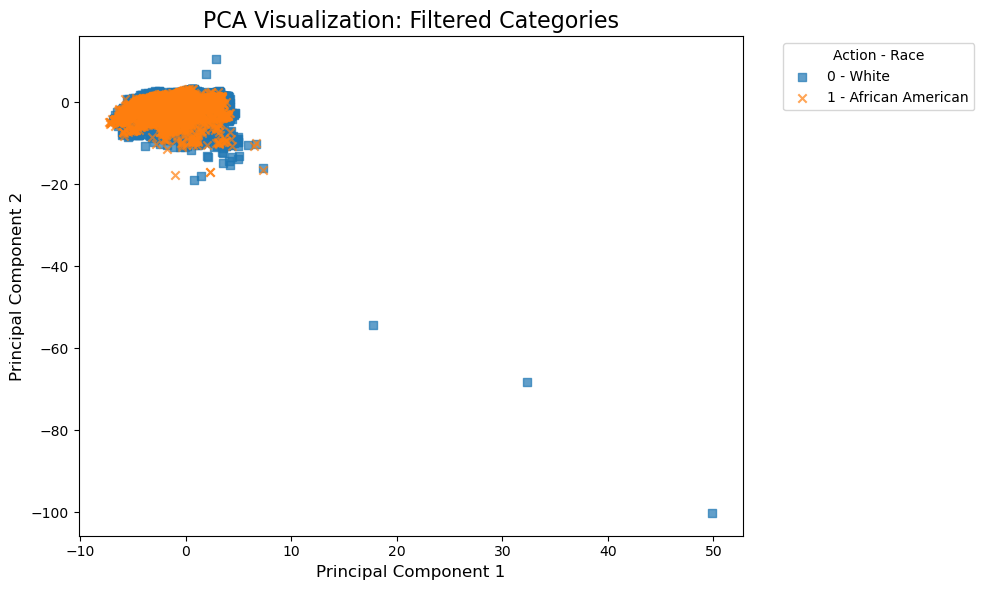

In [ ]:

var_1 = 0
var_2 = 1

# Étape 1 : Sélectionner les colonnes numériques
numeric_cols = df_cleaned.select_dtypes(include=np.number)

# Prendre un échantillon aléatoire (exemple : 10% des données)
df_sampled = df_cleaned.sample(frac=1, random_state=42)

# Standardisation des données
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df_sampled[numeric_cols.columns])

# Étape 2 : Imputer les valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='median')
numeric_imputed = imputer.fit_transform(numeric_scaled)

# Étape 3 : Appliquer PCA avec 2 composantes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_imputed)

# Ajouter les composantes principales au DataFrame échantillonné
df_sampled['PCA1'] = pca_result[:, 0]
df_sampled['PCA2'] = pca_result[:, 1]

# Étape 4 : Filtrer les catégories spécifiques
filtered_df = df_sampled[
    ((df_sampled['action_taken'] == var_1) & (df_sampled['derived_race'] == 'White')) |
    ((df_sampled['action_taken'] == var_2) & (df_sampled['derived_race'] == 'African American'))
]

# Séparer les clusters en fonction de 'action_taken'
white_cluster = df_sampled[(df_sampled['action_taken'] == var_1) & (df_sampled['derived_race'] == 'White')]
black_cluster = df_sampled[(df_sampled['action_taken'] == var_2) & (df_sampled['derived_race'] == 'African American')]

# Fonction pour calculer l'inertie inter-cluster (distance entre les centroïdes)
def calculate_inter_inertia(cluster1_df, cluster2_df, pca_cols):
    centroid1 = cluster1_df[pca_cols].mean(axis=0)
    centroid2 = cluster2_df[pca_cols].mean(axis=0)
    # Calcul de la distance euclidienne entre les deux centroïdes
    inter_inertia = np.sum((centroid1 - centroid2) ** 2)
    return inter_inertia

# Calcul de l'inertie inter-cluster entre les clusters White et Black
inter_inertia = calculate_inter_inertia(white_cluster, black_cluster, ['PCA1', 'PCA2'])

# Affichage de l'inertie inter-cluster
print(f"Inertie inter-cluster entre les clusters White et Black : {inter_inertia}")

# Étape 5 : Visualisation
fig, ax = plt.subplots(figsize=(10, 6))

# Mapper les formes pour la variable 'action_taken'
shapes = {1: 'x', 0: 's'}  # Forme croix pour 1, carré pour 0

# Boucle pour tracer les catégories filtrées
for action in filtered_df['action_taken'].unique():
    subset = filtered_df[filtered_df['action_taken'] == action]
    for race in subset['derived_race'].unique():
        race_subset = subset[subset['derived_race'] == race]
        scatter = ax.scatter(
            race_subset['PCA1'],
            race_subset['PCA2'],
            label=f'{action} - {race}',
            marker=shapes[action],  # Forme selon 'action_taken'
            alpha=0.7
        )

# Ajouter des détails au graphique
ax.set_title('PCA Visualization: Filtered Categories', fontsize=16)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.legend(title='Action - Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Final df for the model 

In [ ]:
final_df = df_cleaned.drop(columns=columns_to_remove_for_model)
final_df.shape

(1776003, 26)

In [ ]:
final_df.columns

Index(['conforming_loan_limit', 'purchaser_type', 'loan_type', 'loan_purpose',
       'lien_status', 'open-end_line_of_credit',
       'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
       'loan_term', 'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'total_units', 'income', 'debt_to_income_ratio', 'applicant_age',
       'applicant_age_above_62', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'GDP', 'is_for_single_family'],
      dtype='object')

In [ ]:
numerical_columns = [ #10 columns
  'GDP',
  'property_value', # a revoir
  'loan_amount',
  'loan_to_value_ratio',
  'loan_term',
  'income',
  'debt_to_income_ratio',
  'applicant_age',
  'tract_minority_population_percent',
  'ffiec_msa_md_median_family_income',
]

binary_columns = [ #9 columns
  'conforming_loan_limit',
  'is_for_single_family',
  'lien_status',
  'open-end_line_of_credit',
  'interest_only_payment',
  'balloon_payment',
  'other_nonamortizing_features',
  'construction_method',
  'applicant_age_above_62',
]
 
categorical_columns = [ #7 columns
  'purchaser_type',
  'loan_type',
  'loan_purpose',
  'business_or_commercial_purpose',
  'occupancy_type',
  'manufactured_home_secured_property_type',
  'total_units',
]
  

In [ ]:
purchaser_type_dummies = pd.get_dummies(final_df['purchaser_type'], prefix='purchaser_type').astype(int)
final_df = pd.concat([final_df, purchaser_type_dummies], axis=1)
final_df.drop('purchaser_type', axis=1, inplace=True)

loan_type_dummies = pd.get_dummies(final_df['loan_type'], prefix='loan_type').astype(int)
final_df = pd.concat([final_df, loan_type_dummies], axis=1)
final_df.drop('loan_type', axis=1, inplace=True)

loan_purpose_dummies =  pd.get_dummies(final_df['loan_purpose'], prefix='loan_purpose').astype(int)
final_df = pd.concat([df_cleaned, loan_purpose_dummies], axis=1)
final_df.drop('loan_purpose', axis=1, inplace=True)

In [64]:
final_df.columns

Index(['conforming_loan_limit', 'purchaser_type', 'loan_type', 'loan_purpose',
       'lien_status', 'open-end_line_of_credit',
       'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
       'loan_term', 'prepayment_penalty_term', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features', 'property_value',
       'construction_method', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units', 'income',
       'debt_to_income_ratio', 'applicant_age', 'applicant_age_above_62',
       'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'GDP', 'is_for_single_family'],
      dtype='object')